<a href="https://colab.research.google.com/github/pethodoma/BME-DeepLearning-BirdCLEF_2023/blob/main/Experimenting_with_tensorflow_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rollback to previous tensorflwo version. The current one is not compatible with tensorflow-io, which is crucial for the audio processing steps in our data pipeline.

In [ ]:
!pip install tensorflow==2.13.0
!pip install tensorflow-io==0.34.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 121.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 46.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 68.2 MB/s eta 0:00:00


In [ ]:
!pip install pydub

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import librosa
import os
import gdown
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
import tensorflow_io as tfio

Download and unzip data

In [ ]:
!wget -O training_files.zip https://www.dropbox.com/scl/fi/2yogrqyao6uypiwtbv8mc/file.zip?rlkey=e3bdpmjvfios021zxlo1ru3b4&dl=0

--2023-11-27 11:59:15--  https://www.dropbox.com/scl/fi/2yogrqyao6uypiwtbv8mc/file.zip?rlkey=e3bdpmjvfios021zxlo1ru3b4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucba2afd5cb544560d4ca1d56996.dl.dropboxusercontent.com/cd/0/inline/CIXHTxy_JGnEIAu9ldyWVW6E4WhbXfZiyRGw1Rc5nj2KFLlViT-j7hN9ttP7kZWKvox6UI3WU5diJTwp1Ur8a41jvbANfqZrSVWB3TLMpzqzXiwcYB2iEYp7ctCdeGs5EWa1HBV1IqAK5QUN-6n-lKe-/file# [following]
--2023-11-27 11:59:15--  https://ucba2afd5cb544560d4ca1d56996.dl.dropboxusercontent.com/cd/0/inline/CIXHTxy_JGnEIAu9ldyWVW6E4WhbXfZiyRGw1Rc5nj2KFLlViT-j7hN9ttP7kZWKvox6UI3WU5diJTwp1Ur8a41jvbANfqZrSVWB3TLMpzqzXiwcYB2iEYp7ctCdeGs5EWa1HBV1IqAK5QUN-6n-lKe-/file
Resolving ucba2afd5cb544560d4ca1d56996.dl.dropboxusercontent.com (ucba2afd5cb544560d4ca1d56996.dl.dropboxusercontent.com)... 162.125.13.15, 2620:100:

In [ ]:
!unzip 'training_files.zip'

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: wavfiles/whbtit5/whbtit5_110495.wav  
  inflating: wavfiles/whbtit5/whbtit5_110472.wav  
   creating: wavfiles/moccha1/
  inflating: wavfiles/moccha1/moccha1_75146.wav  
  inflating: wavfiles/moccha1/moccha1_75065.wav  
  inflating: wavfiles/moccha1/moccha1_74888.wav  
  inflating: wavfiles/moccha1/moccha1_75042.wav  
  inflating: wavfiles/moccha1/moccha1_75399.wav  
  inflating: wavfiles/moccha1/moccha1_75360.wav  
  inflating: wavfiles/moccha1/moccha1_75192.wav  
  inflating: wavfiles/moccha1/moccha1_75303.wav  
  inflating: wavfiles/moccha1/moccha1_74947.wav  
  inflating: wavfiles/moccha1/moccha1_75176.wav  
  inflating: wavfiles/moccha1/moccha1_75278.wav  
  inflating: wavfiles/moccha1/moccha1_74897.wav  
  inflating: wavfiles/moccha1/moccha1_74877.wav  
  inflating: wavfiles/moccha1/moccha1_74989.wav  
  inflating: wavfiles/moccha1/moccha1_74925.wav  
  inflating: wavfiles/moccha1/moccha1_74988.wav  
  inflating: wav

In [ ]:
def read_file_paths(main_dictionary):
    main_directory = main_dictionary
    file_paths = []

    # go through all folders and get the paths of all .ogg audio files
    for root, directories, files in os.walk(main_directory):
        for file in files:
            if file.endswith('.ogg') or file.endswith('.wav'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    # os.walk may not go in alphabetical order thus it needs to be sorted
    file_paths.sort()
    return file_paths

Reading filepaths

In [ ]:
filepaths = read_file_paths('wavfiles')
training_files_df = pd.DataFrame(filepaths, columns=['filepath'])
training_files_df['bird'] = training_files_df['filepath'].apply(lambda x: x.split(os.path.sep)[-1].split('_')[-2])
training_files_df

,filepath,bird
0,wavfiles/abethr1/abethr1_10.wav,abethr1
1,wavfiles/abethr1/abethr1_11.wav,abethr1
2,wavfiles/abethr1/abethr1_13.wav,abethr1
3,wavfiles/abethr1/abethr1_14.wav,abethr1
4,wavfiles/abethr1/abethr1_17.wav,abethr1
...,...,...
13095,wavfiles/yewgre1/yewgre1_122531.wav,yewgre1
13096,wavfiles/yewgre1/yewgre1_122537.wav,yewgre1
13097,wavfiles/yewgre1/yewgre1_122538.wav,yewgre1
13098,wavfiles/yewgre1/yewgre1_122557.wav,yewgre1


In [ ]:
# Let's see if wa have managed to extract chirps from all the birds.
unique_birds = training_files_df['bird'].unique()
len(unique_birds)

262

Creating a dataframe with the categories of all the birds we have sample for.

In [ ]:
bird_categories_df = pd.read_csv('sample_submission.csv').transpose().reset_index().tail(-1).drop(columns=[0,1,2])
bird_categories_df.columns = ['bird']
# It looks like there are two bird species we haven't managed to extract any chirps from. We throw these away from the possibilities
bird_categories_df = bird_categories_df[bird_categories_df['bird'].isin(unique_birds)]
bird_categories_df

,bird
1,abethr1
2,abhori1
3,abythr1
4,afbfly1
5,afdfly1
...,...
260,yertin1
261,yesbar1
262,yespet1
263,yetgre1


In [ ]:
# Fitting the onehotencoder on the bird categories
onehotencoder = OneHotEncoder(sparse_output=False)
onehotencoder.fit(bird_categories_df)

OneHotEncoder(sparse_output=False)

Creating the y values by onehotencoding the labels of the training files

In [ ]:
Y = onehotencoder.transform(pd.DataFrame(training_files_df['bird'], columns=['bird']))
Y.shape

(13100, 262)

Creating the tensor functions for audio preprocessing for our data pipeline

In [ ]:
def load_wav_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    return wav


def preprocess(file_path, label):
    # Making sure wav file is not nolneg than expected
    wav = load_wav_mono(file_path)
    wav = wav[:160000]
    # Creating the actual spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=1024, frame_step=512)
    spectrogram = tf.abs(spectrogram)
    ## Converting it to mel scale
    melspec = tfio.audio.melscale(spectrogram, 32000, 128, 500, 16000)
    #Converting it to decibels
    melspec_dB = 10 * tf.math.log(melspec**2)
    # Converting it to correct shape and size
    melspec_dB = tf.transpose(melspec_dB)
    melspec_dB = tf.expand_dims(melspec_dB, axis=2)
    return melspec_dB, label

Below I printed out the spectrogram of the same file created with both our preprocess function and librosa

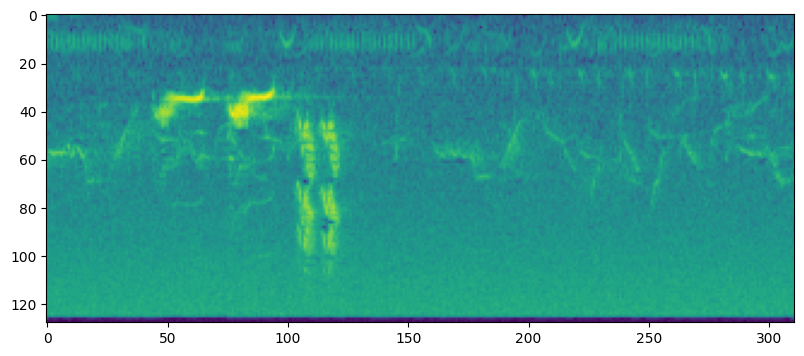

(128, 311, 1)


In [ ]:
specgram, _ = preprocess('wavfiles/abethr1/abethr1_11.wav', _)
plt.figure(figsize=(12, 4))
plt.imshow(specgram)
plt.show()
print(specgram.shape)

(128, 313)

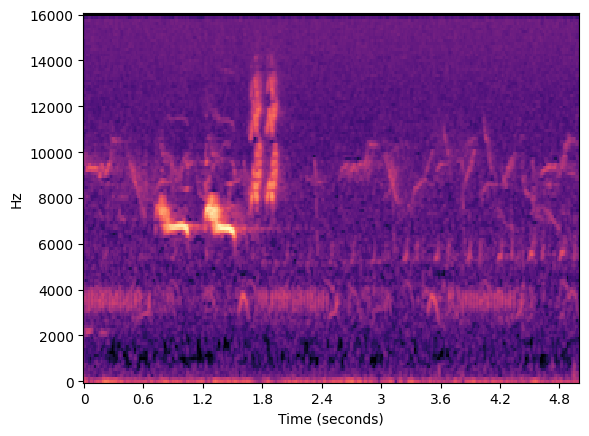

In [ ]:
y, sr = librosa.load(filepath, sr=None)
specgram_libr = librosa.feature.melspectrogram(y=y, sr=sr)
specgram_libr = librosa.power_to_db(specgram_libr)
librosa.display.specshow(specgram_libr, y_axis='hz', x_axis='s', sr=sr)
specgram_libr.shape

Creatng the tensorflow data pipeline

In [ ]:
data = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(filepaths), tf.data.Dataset.from_tensor_slices(Y))

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Test-train split

In [ ]:
train = data.take(600)
valid = data.skip(600).take(100)
test = data.skip(700).take(100)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

Running a training with a simple network to see if our pipeline works.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (5,5), activation='relu', input_shape=(128, 311, 1)))
model.add(tf.keras.layers.Conv2D(16, (5,5), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dense(262, activation='softmax'))

In [ ]:
model.compile('Adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 124, 307, 16)      416       
                                                                 
 conv2d_13 (Conv2D)          (None, 120, 303, 16)      6416      
                                                                 
 flatten_6 (Flatten)         (None, 581760)            0         
                                                                 
 dense_9 (Dense)             (None, 320)               186163520 
                                                                 
 dense_10 (Dense)            (None, 262)               84102     
                                                                 
Total params: 186254454 (710.50 MB)
Trainable params: 186254454 (710.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
600/600 [==============================] - 75s 118ms/step - loss: 32.6903 - recall_3: 0.0029 - precision_3: 0.1250 - val_loss: 6.0399 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 2/4
600/600 [==============================] - 33s 55ms/step - loss: 4.6860 - recall_3: 0.0415 - precision_3: 0.8156 - val_loss: 7.1436 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 3/4
600/600 [==============================] - 33s 55ms/step - loss: 3.6599 - recall_3: 0.1923 - precision_3: 0.9380 - val_loss: 8.1402 - val_recall_3: 6.2500e-04 - val_precision_3: 1.0000
Epoch 4/4
600/600 [==============================] - 33s 54ms/step - loss: 2.6119 - recall_3: 0.4022 - precision_3: 0.9706 - val_loss: 8.9984 - val_recall_3: 6.2500e-04 - val_precision_3: 1.0000


Plotting the outcomes

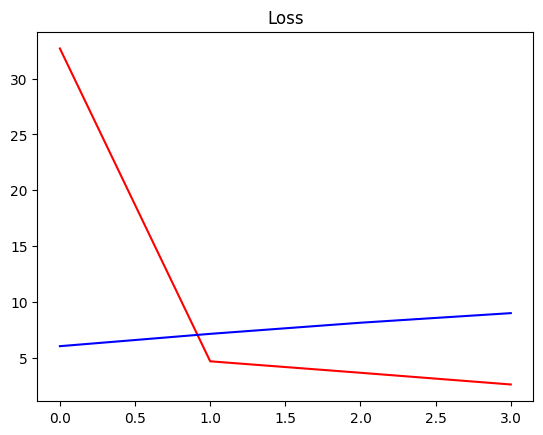

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()